In [66]:
import pandas as pd
import numpy as np
import re
from gensim.models import KeyedVectors
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dropout
from keras.layers import Bidirectional
from keras.optimizers import RMSprop, Adam, SGD, Adagrad
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
training_dataset = pd.read_csv('dataset/train.csv')
testing_dataset = pd.read_csv('dataset/test.csv')

print('train dataset shape: ', training_dataset.shape)
print('train dataset shape: ', testing_dataset.shape)
print('train columns: ', training_dataset.columns)
print('test columns: ', testing_dataset.columns)

train dataset shape:  (9349, 3)
train dataset shape:  (493, 2)
train columns:  Index(['gold_label', 'sentence1', 'sentence2'], dtype='object')
test columns:  Index(['sentence1', 'sentence2'], dtype='object')


In [23]:
NUM_OF_WORDS = 100000

In [3]:
def clean_sents(sentence):
    return re.sub('[^A-Za-z\-]+', ' ', str(sentence)).replace("'", '').lower()

In [17]:
def load_w2v_model(model_path, max_vocab_size=100000):
    return KeyedVectors.load_word2vec_format(model_path, binary=True, limit=max_vocab_size)

In [30]:
def word_embeddings(sentence, word2id_dict):
    return np.array([word2id_dict[word] if word in word2id_dict else 0 for word in sentence.split(' ')])

In [5]:
# def add_paddings(df.col1, df.col2, maxlen):
#     max_seq_len = max( max(df.col1.map(len)), max(df.col2.map(len)) )
#     df.col1 = pad_sequences(df.col1, maxlen=max_seq_len)
#     df.col2 = pad_sequences()
#     return 

In [6]:
train_df = training_dataset.copy()
train_df.sentence1 = train_df.sentence1.apply(clean_sents)
train_df.sentence2 = train_df.sentence2.apply(clean_sents)

In [7]:
X = train_df.drop(['gold_label'], axis=1)
y = train_df[['gold_label']]

In [8]:
y_encoded, y_categories = y['gold_label'].factorize()

In [11]:
y = to_categorical(y_encoded, num_classes=3)

In [19]:
w2v_model = load_w2v_model(model_path='GoogleNews-vectors/GoogleNews-vectors-negative300.bin', max_vocab_size=100000)

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
word2index = {word: i+1 for i, word in enumerate(w2v_model.index2word) if i < NUM_OF_WORDS}

In [50]:
embeddings = w2v_model.vectors[:NUM_OF_WORDS, :]
embeddings = np.concatenate((np.zeros((1,300)), embeddings))
embeddings.shape

(100001, 300)

In [31]:
X['x1'] = X.sentence1.apply(lambda x: word_embeddings(x, word2index))
X['x2'] = X.sentence2.apply(lambda x: word_embeddings(x, word2index))

In [38]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=29)

for train_index, test_index in sss.split(X.drop(['sentence1','sentence2'],axis=1), y):
    X_train = X.drop(['sentence1','sentence2'],axis=1).loc[train_index]
    X_test = X.drop(['sentence1','sentence2'],axis=1).loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

In [41]:
max_seq_len = max( max(X_train.x1.map(len)), max(X_train.x2.map(len)) )

x1_padded = pad_sequences(X_train.x1, maxlen=max_seq_len)
x2_padded = pad_sequences(X_train.x2, maxlen=max_seq_len)

x1_test_padded = pad_sequences(X_test.x1, maxlen=max_seq_len)
x2_test_padded = pad_sequences(X_test.x2, maxlen=max_seq_len)

In [42]:
train_set = np.c_[x1_padded, x2_padded]
test_set = np.c_[x1_test_padded, x2_test_padded]

In [67]:
def build_model():
    model = Sequential()
    model.add(Embedding(embeddings.shape[0], embeddings.shape[1], input_length=max_seq_len*2))
    model.add(GRU(units=32, dropout=(0.4), recurrent_dropout=(0.4)))
    model.add(Dropout(rate=0.4))
    model.add(Dense(3, activation='softmax'))
    print(model.summary())

    optimizer = RMSprop(lr=0.001, epsilon=1e-08) #Adam(lr=0.001, epsilon=1e-08)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


filepath = "keras-model-epoch-{epoch:02d}-val_acc-{val_acc:.4f}.hdf5"
chk_point = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
callbacks_list = [early_stop, chk_point]

keras_model = build_model()
history = keras_model.fit(train_set, y_train, batch_size=32, epochs=10, validation_data=(test_set, y_test), 
                          callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 102, 300)          30000300  
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                31968     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 30,032,367
Trainable params: 30,032,367
Non-trainable params: 0
_________________________________________________________________
None
Train on 7479 samples, validate on 1870 samples
Epoch 1/10
7479/7479 [==============================] - 61s 8ms/step - loss: 0.6131 - acc: 0.6760 - val_loss: 0.5824 - val_acc: 0.6968

Epoch 00001: val_acc improved from -inf to 0.69679, saving model to keras

In [68]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

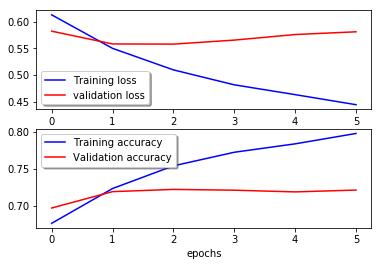

In [73]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.xlabel("epochs")

plt.show()

In [74]:
test_df = testing_dataset.copy()
test_df.sentence1 = test_df.sentence1.apply(clean_sents)
test_df.sentence2 = test_df.sentence2.apply(clean_sents)

In [75]:
test_df['x1'] = test_df.sentence1.apply(lambda x: word_embeddings(x, word2index))
test_df['x2'] = test_df.sentence2.apply(lambda x: word_embeddings(x, word2index))

In [77]:
X_new = test_df[['x1','x2']]

x1_padded = pad_sequences(X_new.x1, maxlen=max_seq_len)
x2_padded = pad_sequences(X_new.x2, maxlen=max_seq_len)

X_new_prepared = np.c_[x1_padded, x2_padded]

In [80]:
final_pred = keras_model.predict(X_new_prepared)

In [91]:
final_pred.shape

(493, 3)

In [95]:
final_pred = np.argmax(final_pred, axis=1)

In [97]:
y_categories

Index(['contradiction', 'entailment', 'neutral'], dtype='object')

In [98]:
y_encoded

array([0, 1, 2, ..., 2, 0, 1], dtype=int64)

In [99]:
final_pred[:5]

array([0, 2, 0, 1, 2], dtype=int64)

In [104]:
final_df = pd.DataFrame(columns=['gold_label'])
for ix, pred in enumerate(final_pred):
    if pred == 0:
        final_df.loc[len(final_df), 'gold_label'] = 'contradiction'
    elif pred == 1:
        final_df.loc[len(final_df), 'gold_label'] = 'entailment'
    else:
        final_df.loc[len(final_df), 'gold_label'] = 'neutral'

In [106]:
final_df.to_csv('predicted.csv', index=False)
final_df.head()

,gold_label
0,contradiction
1,neutral
2,contradiction
3,entailment
4,neutral


In [107]:
len(final_df)

493